In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load Dataset

In [3]:

np.random.seed(42)


dataset_path = '/kaggle/input/att-database-of-faces'

data = []
labels = []

for subject_id in range(1, 41): 
    subject_path = os.path.join(dataset_path, f's{subject_id}')
    for image_name in sorted(os.listdir(subject_path)):
        image_path = os.path.join(subject_path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_flat = img.flatten()
        data.append(img_flat)
        labels.append(subject_id)

# Convert to numpy arrays
D = np.array(data)        
y = np.array(labels)       

print(f'Data matrix D shape: {D.shape}')
print(f'Label vector y shape: {y.shape}')

Data matrix D shape: (400, 10304)
Label vector y shape: (400,)


# Split the Dataset

In [4]:
train_indices = []
test_indices = []

for i in range(0, D.shape[0], 10):
    # For each subject, 10 images
    train_indices.extend([i, i+2, i+4, i+6, i+8])  # odd indexes
    test_indices.extend([i+1, i+3, i+5, i+7, i+9]) # even indexes

X_train = D[train_indices]
y_train = y[train_indices]
X_test = D[test_indices]
y_test = y[test_indices]

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')


Train set shape: (200, 10304)
Test set shape: (200, 10304)


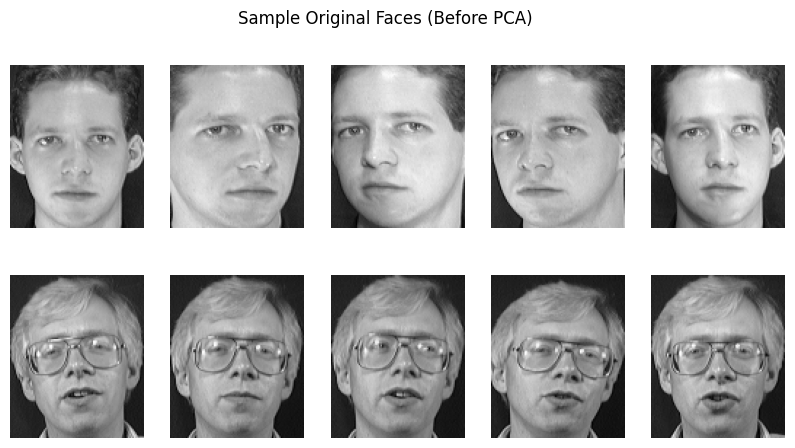

In [11]:
def plot_original_faces(X, title="Original Faces"):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(X[i].reshape(112, 92), cmap='gray')  
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_original_faces(X_train, "Sample Original Faces (Before PCA)")


# PCA from scratch

In [16]:
class PCA_scratch:
    def __init__(self):
        self.mean = None
        self.components = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # 1. Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # 2. Compute covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)
        
        # 3. Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # 4. Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        self.components = eigenvectors
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues / total_variance

    def transform(self, X, variance_threshold=0.9):
        X_centered = X - self.mean
        cumulative_variance = np.cumsum(self.explained_variance_ratio)
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        W = self.components[:, :n_components]  # Take top eigenvectors
        return X_centered @ W, n_components

pca = PCA_scratch()
pca.fit(X_train)


alphas = [0.8, 0.85, 0.9, 0.95]
X_train_pca = {}

for alpha in alphas:
    X_reduced, n_components = pca.transform(X_train, variance_threshold=alpha)
    X_train_pca[alpha] = X_reduced
    print(f'Alpha {alpha}: reduced dimensionality = {n_components} components')

Alpha 0.8: reduced dimensionality = 36 components
Alpha 0.85: reduced dimensionality = 52 components
Alpha 0.9: reduced dimensionality = 76 components
Alpha 0.95: reduced dimensionality = 115 components


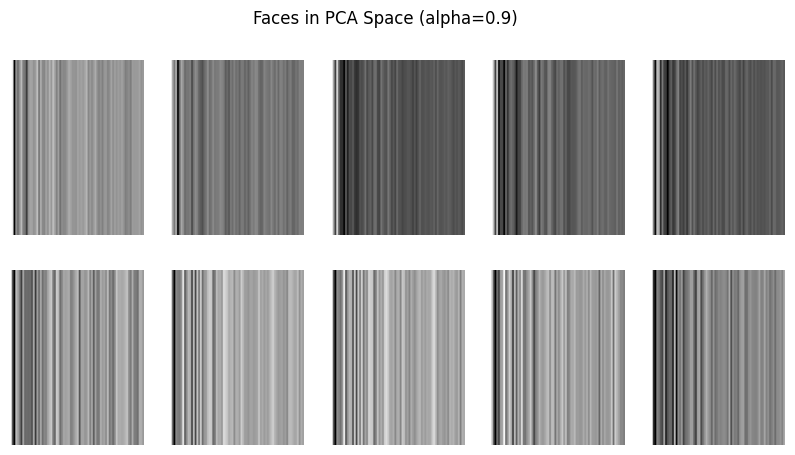

In [17]:
def plot_sample_faces(X_pca, title):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(X_pca[i].reshape(1, -1), cmap='gray', aspect='auto')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Example for alpha = 0.9
plot_sample_faces(X_train_pca[0.9], "Faces in PCA Space (alpha=0.9)")

Alpha 0.8: reduced dimensionality = 36 components
Alpha 0.85: reduced dimensionality = 52 components
Alpha 0.9: reduced dimensionality = 76 components
Alpha 0.95: reduced dimensionality = 115 components


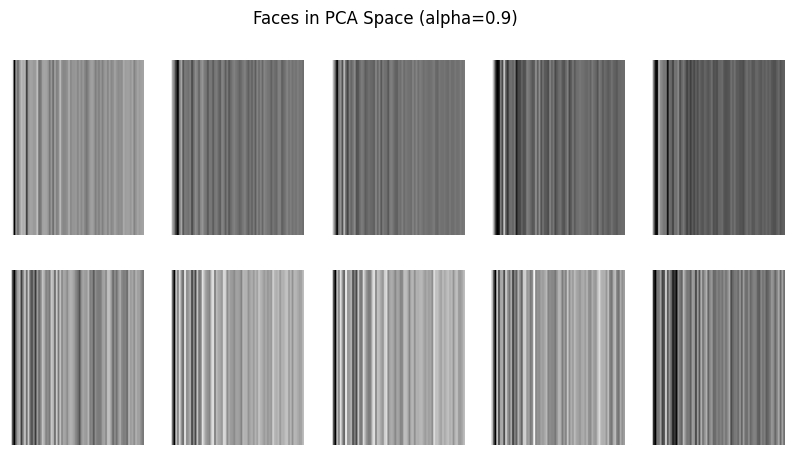

In [15]:
# from sklearn.decomposition import PCA
# def apply_pca(X, variance_threshold=0.9):
#     pca = PCA()
#     pca.fit(X)
    
#     # Cumulative explained variance
#     cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
#     # Find number of components to retain the given variance
#     n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
#     # Apply PCA with the found number of components
#     pca = PCA(n_components=n_components)
#     X_reduced = pca.fit_transform(X)
    
#     return X_reduced, pca

# # Try for alpha = 0.8
# alphas = [0.8, 0.85, 0.9, 0.95]
# pca_models = {}
# X_train_pca = {}

# for alpha in alphas:
#     X_reduced, pca_model = apply_pca(X_train, variance_threshold=alpha)
#     pca_models[alpha] = pca_model
#     X_train_pca[alpha] = X_reduced
#     print(f'Alpha {alpha}: reduced dimensionality = {X_reduced.shape[1]} components')

# # --- Optional: Visualize a few images in PCA space ---
# def plot_sample_faces(X_pca, title):
#     plt.figure(figsize=(10,5))
#     for i in range(10):
#         plt.subplot(2,5,i+1)
#         plt.imshow(X_pca[i].reshape(1,-1), cmap='gray', aspect='auto')
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.show()

# # Example for alpha = 0.9
# plot_sample_faces(X_train_pca[0.9], "Faces in PCA Space (alpha=0.9)")

# Bonus not finished yet

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim=10304, bottleneck_dim=50):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, bottleneck_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # output in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [19]:
# Normalize pixel values to [0,1]
X_train_norm = X_train / 255.0

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = X_train_tensor.to(device)


In [20]:
# Instantiate model
autoencoder = Autoencoder(input_dim=10304, bottleneck_dim=50).to(device)

# Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
epochs = 100
batch_size = 64

print("Training Autoencoder...")
for epoch in range(epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch = X_train_tensor[indices]
        
        # Forward pass
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


Training Autoencoder...
Epoch 10/100, Loss: 0.021553
Epoch 20/100, Loss: 0.018313
Epoch 30/100, Loss: 0.014383
Epoch 40/100, Loss: 0.013798
Epoch 50/100, Loss: 0.011139
Epoch 60/100, Loss: 0.009805
Epoch 70/100, Loss: 0.008603
Epoch 80/100, Loss: 0.008194
Epoch 90/100, Loss: 0.006243
Epoch 100/100, Loss: 0.006147


In [21]:
# Switch to evaluation mode
autoencoder.eval()

# Extract bottleneck features
with torch.no_grad():
    features = autoencoder.encoder(X_train_tensor).cpu().numpy()

print(f"Bottleneck features shape: {features.shape}")  


Bottleneck features shape: (200, 50)


In [22]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# Apply K-Means
kmeans = KMeans(n_clusters=40, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

# Apply GMM
gmm = GaussianMixture(n_components=40, random_state=42)
gmm_labels = gmm.fit_predict(features)



print("K-Means clustering done.")
print("GMM clustering done.")


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering done.
GMM clustering done.


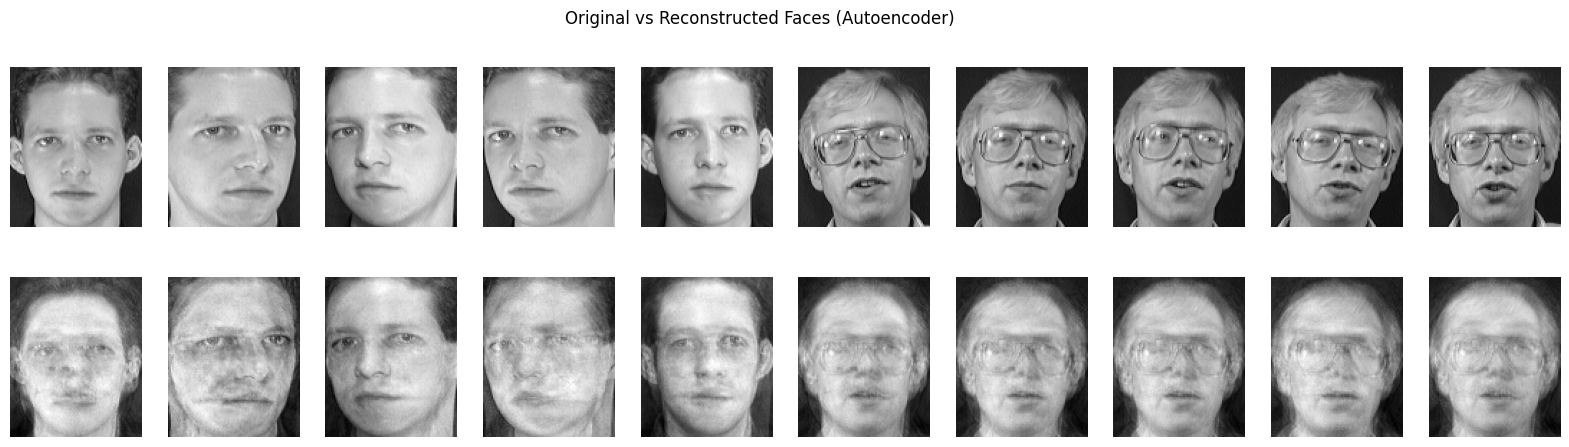

In [24]:
# Reconstruct some images
with torch.no_grad():
    reconstructed = autoencoder(X_train_tensor).cpu().numpy()

def plot_reconstructed_faces(originals, reconstructed, title="Reconstructed Faces"):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        # Original
        plt.subplot(2, 10, i+1)
        plt.imshow(originals[i].reshape(112,92), cmap='gray')
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, 10, i+11)
        plt.imshow(reconstructed[i].reshape(112,92), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_reconstructed_faces(X_train_norm, reconstructed, title="Original vs Reconstructed Faces (Autoencoder)")
